In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
### 使用 networkx 包中的函数 LFR_benchmark_graph 生成随机图
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1 # Power-law exponent for the community size distribution 
            #S hould be >1
mu = 0.1 # Mixing parameter
avg_deg = 25 # Average Degree
max_deg = int(0.1*n) # Max Degree
min_commu = 60 # Min Community Size
max_commu = int(0.1*n) # Max Community Size

G0 = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu, 
    seed=7
)
### 去掉 G 中的重边和自环 
G0 = nx.Graph(G0) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G0)) # a list of self loops

G0.remove_edges_from(selfloop_edges) # Remove self-loops

In [3]:
import numpy as np
intrinsic_communities = {frozenset(G0.nodes[v]["community"]) for v in G0}
intrinsic_membership = np.empty(G0.number_of_nodes(), dtype=int)
for node in range(G0.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break

In [4]:
import os
from datetime import date
def generate_output(disturb: bool, filename):
    # Generate the folder name with the current date
    if disturb:   
        folder_name = f"Graph_Rmv_Stoch_{date.today()}"
    else:
        folder_name = f"Graph_Rmv_Btwn_{date.today()}"

    # Create the output directory if it doesn't exist
    output_dir = os.path.join(os.getcwd(), folder_name)
    os.makedirs(output_dir, exist_ok=True)

    # Construct the full file path
    file_path = os.path.join(output_dir, filename)
    
    return file_path

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import StrMethodFormatter

def quar_plot(scores, disturb: bool, filename, win:10):
    data = scores
    # Extract x and y coordinates for each curve
    x = range(len(data))  # Use the length of data as x-coordinates
    y = list(zip(*data))  # Transpose the data matrix

    # Compute rolling mean with a window size of win
    y_smoothed = [pd.Series(curve).rolling(window=win, min_periods=1).mean() for curve in y]
    #print(y_smoothed)
    # Create subplots
    fig, axs = plt.subplots(len(y_smoothed), 1, sharex=True)

    # Plot each curve with smoothed data on a separate subplot
    ylabel = ["NMI Eucl", "NMI Cosn", "ECS Eucl", "ECS Cosn"]

    for i, curve in enumerate(y_smoothed):
        axs[i].plot(x, curve)
        axs[i].set_ylabel(ylabel[i]) 
        axs[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))
    
    # Add x-axis label to the last subplot
    axs[-1].set_xlabel('Number of Removed Vertices')

    # Adjust spacing between subplots
    plt.tight_layout()
    
    file_path = generate_output(disturb, filename+".png")
    plt.savefig(file_path)    
    
    # Show the plot
    plt.show()

In [6]:
import os
import csv
from datetime import date

def save_scores_to_csv(scores, disturb: bool, filename):
    """
    Saves a list of 4-lists to a CSV file with a double space separator.
    
    Args:
        scores (list): The list of 4-lists to be saved.
        filename (str): The name of the output CSV file.
    """
    # Construct the full file path
    file_path = generate_output(disturb, filename+".csv")

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=' ')
        for score_list in scores:
            writer.writerow(score_list)

In [8]:
betweenness = nx.betweenness_centrality(G0)
temp = sorted(betweenness, key=betweenness.get, reverse=True)

In [9]:
from auxpack.eval_embd import eval_embd as EE
from clusim.clustering import Clustering

D=20
K = len(np.unique(intrinsic_membership))
wk=32
#Measure = []
#remain_nodes = np.array(range(G.number_of_nodes()))

Vertex 917 is removed. NMI&ECS: [0.9461477426077881, 0.9885139761685772, 0.8792734198098169, 0.9864615079400025]
Vertex 297 is removed. NMI&ECS: [0.9445555609209234, 0.9885028112337145, 0.8732541700807973, 0.986447942316696]
Vertex 393 is removed. NMI&ECS: [0.9373812898538662, 0.9956789656175375, 0.8638204970961553, 0.9940878696696149]
Vertex 360 is removed. NMI&ECS: [0.9339220094987961, 0.9935907305736568, 0.8590461386443897, 0.9911772993851308]
Vertex 652 is removed. 

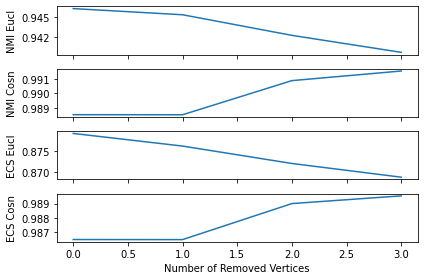

CPU times: user 2min 1s, sys: 2min 34s, total: 4min 36s
Wall time: 3.48 s


In [10]:
%%time
### 1 Hope 方法
from gem.embedding.hope import HOPE  

idx = [True] *(G0.number_of_nodes())
G=G0.copy()

scores=[]

for i in temp:
    G.remove_node(i)
    print(f"Vertex {i} is removed.", end=' ')
    if not nx.is_connected(G):
        print("In total", temp.index(i), "vertices are removed. G is now disconnected!!")
        break
    
    hope_model = HOPE(d=D, beta=0.01) 
    # A higher value of beta places more emphasis on capturing higher-order proximities
    embd = hope_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
    
    idx[i] = False
    intrin_list = intrinsic_membership[idx]
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    K = len(np.unique(intrinsic_membership[idx]))
    score = EE(K,intrin_list,intrin_Clus, embd)
    scores.append(score)
    print("NMI&ECS:", score)
    
quar_plot(scores=scores, disturb=False, filename="1HOPE", win=10)
save_scores_to_csv(scores, False, "1HOPE")
#Measure.append(scores)

Vertex 917 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 297 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 393 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 360 is removed. NMI&ECS: [1.0000000000000002, 1.0, 1.0, 1.0]
Vertex 652 is removed. 

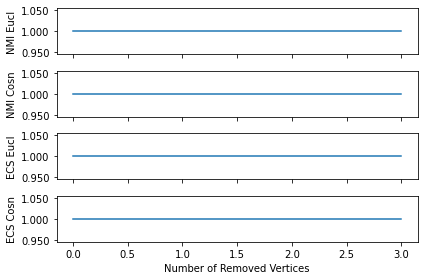

CPU times: user 1min 57s, sys: 2min 34s, total: 4min 32s
Wall time: 3.49 s


In [11]:
%%time
### 2 Laplacian 方法
from gem.embedding.lap import LaplacianEigenmaps

idx = [True] *(G0.number_of_nodes())
G=G0.copy()

scores=[]

for i in temp:
    G.remove_node(i)
    print(f"Vertex {i} is removed.", end=' ')
    if not nx.is_connected(G):
        print("In total", temp.index(i), "vertices are removed. G is now disconnected!!")
        break

    lap_model = LaplacianEigenmaps(d=D)
    embd = lap_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
    
    idx[i] = False
    intrin_list = intrinsic_membership[idx]
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    K = len(np.unique(intrinsic_membership[idx]))
    score = EE(K,intrin_list,intrin_Clus, embd)
    scores.append(score)
    print("NMI&ECS:", score)
    
quar_plot(scores=scores, disturb=False, filename="2LAP", win=10)
save_scores_to_csv(scores, False, "2LAP")
#Measure.append(scores)

Vertex 917 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 297 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 393 is removed. NMI&ECS: [0.9999999999999998, 1.0, 1.0, 1.0]
Vertex 360 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 652 is removed. 

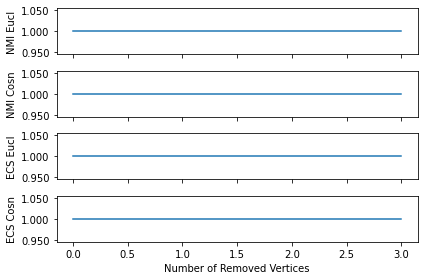

CPU times: user 3min 8s, sys: 4min 48s, total: 7min 57s
Wall time: 6.11 s


In [12]:
%%time
### 3 LLE 方法
from auxpack.lle import lle

idx = [True] *(G0.number_of_nodes())
G=G0.copy()

scores=[]

for i in temp:
    G.remove_node(i)
    print(f"Vertex {i} is removed.", end=' ')
    if not nx.is_connected(G):
        print("In total", temp.index(i), "vertices are removed. G is now disconnected!!")
        break

    embd = lle(G, D)
    
    idx[i] = False
    intrin_list = intrinsic_membership[idx]
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    K = len(np.unique(intrinsic_membership[idx]))
    score = EE(K,intrin_list,intrin_Clus, embd)
    scores.append(score)
    print("NMI&ECS:", score)
    
quar_plot(scores=scores, disturb=False, filename="3LLE", win=10)
save_scores_to_csv(scores, False, "3LLE")
#Measure.append(scores)

Vertex 917 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 297 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 393 is removed. NMI&ECS: [0.9999999999999998, 1.0, 1.0, 1.0]
Vertex 360 is removed. NMI&ECS: [1.0000000000000002, 1.0000000000000002, 1.0, 1.0]
Vertex 652 is removed. 

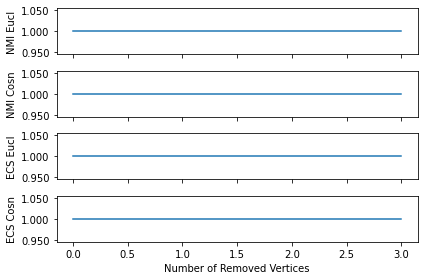

CPU times: user 1min 47s, sys: 1min 51s, total: 3min 39s
Wall time: 15.2 s


In [13]:
%%time
### 4 DeepWalk方法
from auxpack.DeepWalk import DeepWalk

idx = [True] *(G0.number_of_nodes())
G=G0.copy()

scores=[]

for i in temp:
    G.remove_node(i)
    print(f"Vertex {i} is removed.", end=' ')
    if not nx.is_connected(G):
        print("In total", temp.index(i), "vertices are removed. G is now disconnected!!")
        break
 
    model = DeepWalk(dimensions=D, walk_length=16, window_size=10, walk_number=10, workers=wk)
    model.fit(G)
    embd = model.get_embedding()
    
    idx[i] = False
    intrin_list = intrinsic_membership[idx]
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    K = len(np.unique(intrinsic_membership[idx]))
    score = EE(K,intrin_list,intrin_Clus, embd)
    scores.append(score)
    print("NMI&ECS:", score)
    
quar_plot(scores=scores, disturb=False, filename="4DeepWalk", win=10)
save_scores_to_csv(scores, False, "4DeepWalk")
#Measure.append(scores)

Vertex 917 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 297 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 393 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 360 is removed. NMI&ECS: [1.0000000000000002, 1.0000000000000002, 1.0, 1.0]
Vertex 652 is removed. 

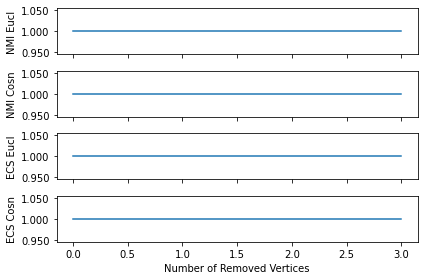

CPU times: user 4min 17s, sys: 11min 2s, total: 15min 19s
Wall time: 14 s


In [14]:
%%time
### 5 MNMF 方法
from karateclub import MNMF

idx = [True] *(G0.number_of_nodes())
G=G0.copy()

scores=[]

for i in temp:
    G.remove_node(i)
    print(f"Vertex {i} is removed.", end=' ')
    if not nx.is_connected(G):
        print("In total", temp.index(i), "vertices are removed. G is now disconnected!!")
        break

    # Create an instance of the MNMF model
    MNMF_model = MNMF(dimensions = D, clusters = K, lambd = 0.2, 
                 alpha = 0.05, beta = 0.05, iterations = 100, 
                 lower_control = 1e-15, eta = 5.0, seed = 42)

    # Fit the model to the graph
    H = nx.relabel.convert_node_labels_to_integers(G)
    MNMF_model.fit(H)
    # Obtain the graph embeddings
    embd = MNMF_model.get_embedding()
    
    idx[i] = False
    intrin_list = intrinsic_membership[idx]
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    K = len(np.unique(intrinsic_membership[idx]))
    score = EE(K,intrin_list,intrin_Clus, embd)
    scores.append(score)
    print("NMI&ECS:", score)
    
quar_plot(scores=scores, disturb=False, filename="5MNMF", win=10)
save_scores_to_csv(scores, False, "5MNMF")
#Measure.append(scores)

Vertex 917 is removed. 

2023-07-05 02:16:02.997531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 02:16:03.888103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 731 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:02:00.0, compute capability: 8.0
2023-07-05 02:16:03.889494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37692 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 297 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 393 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 360 is removed. 

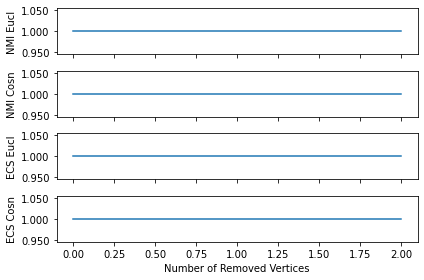

CPU times: user 1min 35s, sys: 1min 23s, total: 2min 58s
Wall time: 25.2 s


In [16]:
%%time
### 6 LINE 方法
from ge import LINE

idx = [True] *(G0.number_of_nodes())
G=G0.copy()

scores=[]

for i in temp:
    G.remove_node(i)
    print(f"Vertex {i} is removed.", end=' ')
    if not nx.is_connected(G):
        print("In total", temp.index(i), "vertices are removed. G is now disconnected!!")
        break
        
    model = LINE(G,embedding_size=D,order='first');
    model.train(batch_size=8192,epochs=50,verbose=0);# train model
    LINE_embd = model.get_embeddings();# get embedding vectors
    embd = list(LINE_embd.values())
    
    idx[i] = False
    intrin_list = intrinsic_membership[idx]
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    K = len(np.unique(intrinsic_membership[idx]))
    score = EE(K,intrin_list,intrin_Clus, embd)
    scores.append(score)
    print("NMI&ECS:", score)
    
quar_plot(scores=scores, disturb=False, filename="6LINE", win=10)
save_scores_to_csv(scores, False, "6LINE")
#Measure.append(scores)

Vertex 917 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 297 is removed. NMI&ECS: [1.0, 1.0, 1.0, 1.0]
Vertex 393 is removed. NMI&ECS: [0.9999999999999998, 1.0, 1.0, 1.0]
Vertex 360 is removed. NMI&ECS: [1.0, 1.0000000000000002, 1.0, 1.0]
Vertex 652 is removed. 

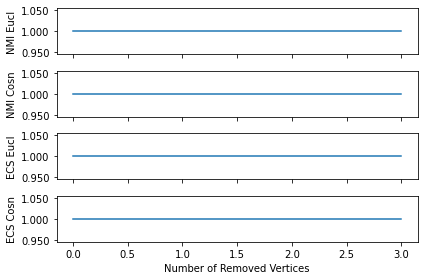

CPU times: user 2min 56s, sys: 2min 2s, total: 4min 59s
Wall time: 1min 11s


In [15]:
%%time
### 7 Node2Vec 方法 以后使用这个
from node2vec import Node2Vec

nodes_range = np.array(range(G0.number_of_nodes()))
idx = [True] *(G0.number_of_nodes())
G=G0.copy()

scores=[]

for i in temp:
    G.remove_node(i)
    print(f"Vertex {i} is removed.", end=' ')
    if not nx.is_connected(G):
        print("In total", temp.index(i), "vertices are removed. G is now disconnected!!")
        break
    
    # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
    node2vec_model = Node2Vec(G, dimensions=D, walk_length=16, num_walks=10, workers=wk, quiet=True) #, temp_folder='test' # Use temp_folder for big graphs
    # Embed nodes 
    node2vec_fit = node2vec_model.fit(window=10, min_count=1, batch_words=20000)  
    # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed 
    # (from the Node2Vec constructor)

    idx[i] = False

    nodes = [str(x) for x in nodes_range[idx]]
    embd = np.array([node2vec_fit.wv[node] for node in nodes])
    
    intrin_list = intrinsic_membership[idx]
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    K = len(np.unique(intrinsic_membership[idx]))
    score = EE(K,intrin_list,intrin_Clus, embd)
    scores.append(score)
    print("NMI&ECS:", score)
    
quar_plot(scores=scores, disturb=False, filename="7Node2Vec", win=10)
save_scores_to_csv(scores, False, "7Node2Vec")
#Measure.append(scores)